# Проект - телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

## Цели проекта
1. Изучить данные
2. Обучить модель для прогноза оттока клиентов
3. Сформулировать общий вывод и рекомендации для компании

## План работы
1. Загрузить данные и ознакомиться с ними
2. Провести исследовательский анализ и выполнить предобработку данных
3. Подготовить данные для обучения модели
4. Обучить несколько моделей
5. Выбрать лучшую модель
6. Сформулировать общий вывод и рекомендации

Загружаю необходимые для работы бибилотеки

In [1]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 10.7 MB/s eta 0:00:00


In [2]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00


In [3]:
!pip install shap -q

In [4]:
!pip install plotly -q

In [5]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.7 MB/s eta 0:00:00


In [6]:
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap
import plotly.express as px
import scipy.stats as st
import optuna
from optuna.samplers import TPESampler

In [7]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

## 1 Загрузка и ознакомление с данными

Считываю файлы и создаю датафреймы

In [76]:
contract_df = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal_df = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet_df = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone_df = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

При помощи небольшой функции вывожу основную информацию и превые строки каждого датафрейма

In [77]:
def info(data):
  return data.info(), display(data.head(6))

In [78]:
info(contract_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96


(None, None)

In [11]:
info(personal_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No


(None, None)

In [12]:
info(internet_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes


(None, None)

In [13]:
info(phone_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes


(None, None)

**Вывод**: При первичном знакомстве с данными не выявлено пропусков. Типы данных не везде соответствуют фактическим. Видны различия в количестве строк, что говорит о том, что клиенты могут пользоваться не всеми видами услуг, которые предоставляет оператор. В целом данные соответствуют описанию.

## 2 Предобработка данных

### 2.1 Приведение названий столбцов к единому стилю

Прописываю функции и перевожу названия столбцов к "змеиному языку"

In [14]:
def camel_to_snake(column_name):

    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)

    result = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s)

    return result.lower()

def normalize(df):

    df.columns = [camel_to_snake(col) for col in df.columns]
    return df

In [15]:
normalize(contract_df)
contract_df.head(1)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04


In [16]:
normalize(personal_df)
personal_df.head(1)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No


In [17]:
normalize(internet_df)
internet_df.head(1)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [18]:
normalize(phone_df)
phone_df.head(1)

,customer_id,multiple_lines
0,5575-GNVDE,No


### 2.2 Работа с типами данных

Меняю тип данных в столбце с фактическим доходом от клиента за все время

In [19]:
contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'], errors='coerce')
contract_df['total_charges'].dtype

dtype('float64')

Далее меняю тип данных в столбцах с датами

In [20]:
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'])
contract_df['begin_date'].dtype

dtype('<M8[ns]')

In [21]:
contract_df['end_date'] = pd.to_datetime(contract_df['end_date'], errors='coerce')
contract_df['end_date'].dtype

/tmp/ipython-input-3192217664.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract_df['end_date'] = pd.to_datetime(contract_df['end_date'], errors='coerce')


dtype('<M8[ns]')

Признак senior_citizen является по сути качественным признаком, поэтому стоит поменять тип данных на object.

In [22]:
personal_df['senior_citizen'] = personal_df['senior_citizen'].astype('object')
personal_df['senior_citizen'].dtype

dtype('O')

### 2.3 Работа с дубликатами

Вывожу количество явных дубликатов в каждом датафрейме

In [23]:
print(contract_df.duplicated().sum())
print(personal_df.duplicated().sum())
print(internet_df.duplicated().sum())
print(phone_df.duplicated().sum())

0
0
0
0


При помощи функции проверяю наличие неявных дубликатов, опечаток

In [24]:
def dulbicates(data):
    for column in data:
        if data[column].dtype == 'object':
            print(column, data[column].unique())

In [25]:
dulbicates(contract_df)

customer_id ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
type ['Month-to-month' 'One year' 'Two year']
paperless_billing ['Yes' 'No']
payment_method ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [26]:
dulbicates(personal_df)

customer_id ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
senior_citizen [0 1]
partner ['Yes' 'No']
dependents ['No' 'Yes']


In [27]:
dulbicates(internet_df)

customer_id ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
internet_service ['DSL' 'Fiber optic']
online_security ['No' 'Yes']
online_backup ['Yes' 'No']
device_protection ['No' 'Yes']
tech_support ['No' 'Yes']
streaming_tv ['No' 'Yes']
streaming_movies ['No' 'Yes']


In [28]:
dulbicates(phone_df)

customer_id ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
multiple_lines ['No' 'Yes']


### 2.4 Работа с пропусками

Исследую пропуски, образовавшиеся после изменения типа данных в total_charges

In [29]:
missing_total = contract_df.query('total_charges.isna()')
missing_total

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


Пропуски явно связаны с тем, что это данные о новых клиентах. Дата начала контракта совпадает с датой актуальности данных. Компания просто еще не успела получить прибыль от этих клиентов или по крайней мере данных еще не было в базе на момент выгрузки. Было бы логично заменить пропущенные значения на ноль.

In [30]:
contract_df['total_charges'].fillna(0, inplace=True)

/tmp/ipython-input-1463545804.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract_df['total_charges'].fillna(0, inplace=True)


In [31]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


## 3 Объединение таблиц

### 3.1 Объединение

Перевожу столбец с id пользователей в индекс во всех датафреймах

In [32]:
contract_df = contract_df.set_index('customer_id')
personal_df = personal_df.set_index('customer_id')
internet_df = internet_df.set_index('customer_id')
phone_df = phone_df.set_index('customer_id')

In [33]:
eda_frame = contract_df.join(personal_df, how='outer')
eda_frame = eda_frame.join(internet_df, how ='outer')
eda_frame = eda_frame.join(phone_df, how='outer')

Вывожу информацию о получившейся таблице и первые строки

In [34]:
eda_frame.info()
eda_frame.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   object        
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   5517 non-null   object        
 12  online_security    5517 non-null   object        
 13  online_backup      5517 non-null   object        
 14

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,539.10,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
0004-TLHLJ,2019-09-01,NaT,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
0011-IGKFF,2018-12-01,NaT,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
0013-EXCHZ,2019-09-01,NaT,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


### 3.2 Обработка пропусков

Заменяю пропущенные значения в столбцах с 'internet_service' и 'multiple_lines' на no_package, т.е. нет пакета услуг. В остальных столбцах на no_service, т.е. нет услуги в пакете.

In [35]:
eda_frame['internet_service'] = eda_frame['internet_service'].fillna('no_package')

In [36]:
eda_frame['multiple_lines'] = eda_frame['multiple_lines'].fillna('no_package')

In [37]:
columns_to_fill = [col for col in eda_frame.columns if col != 'end_date']

eda_frame[columns_to_fill] = eda_frame[columns_to_fill].fillna('no_service')

/tmp/ipython-input-622031514.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eda_frame[columns_to_fill] = eda_frame[columns_to_fill].fillna('no_service')


In [38]:
eda_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           1101 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

### 3.3 Добавление целевого признака

Добавляю целевой признак - ушел клиент или остался.

In [39]:
eda_frame['quit'] = eda_frame['end_date'].apply(
    lambda x: 'No' if pd.isna(x) else 'Yes'
)

In [40]:
eda_frame.head(5)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,quit
customer_id,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,NaT,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,No
0003-MKNFE,2019-05-01,NaT,Month-to-month,No,Mailed check,59.9,539.10,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes,No
0004-TLHLJ,2019-09-01,NaT,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No,No
0011-IGKFF,2018-12-01,NaT,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,No
0013-EXCHZ,2019-09-01,NaT,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,No


## 4 Исследовательский анализ данных

### 4.1 Даты начала и окончания пользования услугами

Строю графики распределения начала и окончания пользования услугами помпании. В датах с окончанием пользования делаю срез, чтобы отображать данные только тех пользователей, которые уже закончили свое пользование

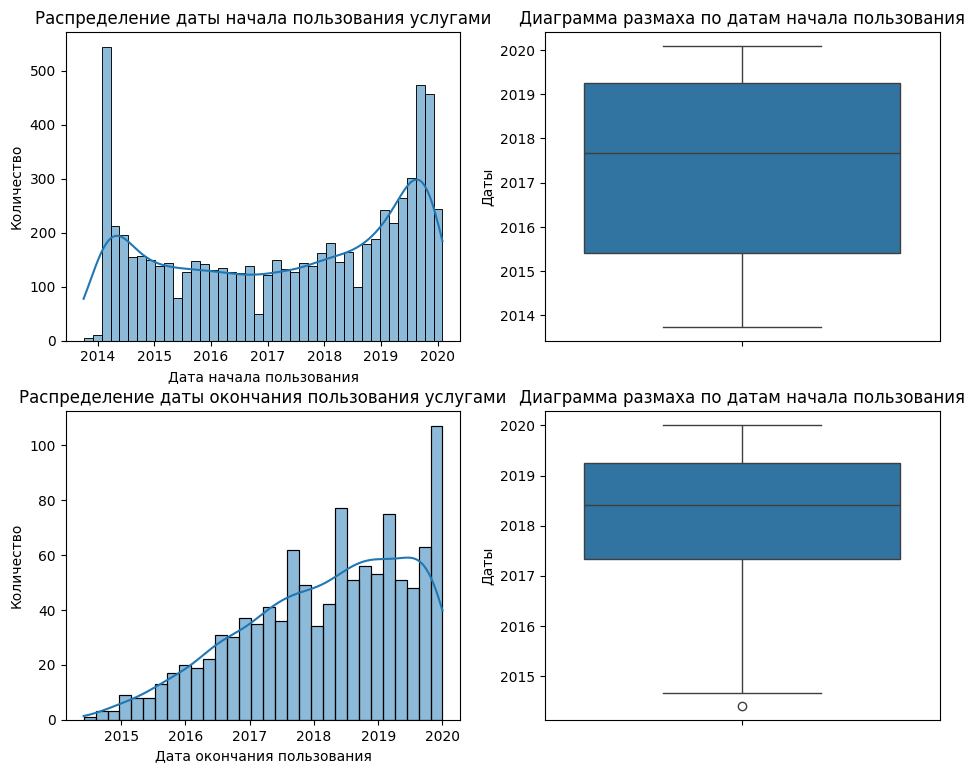

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plt.tight_layout(pad=3.0)

sns.histplot(data=eda_frame, x='begin_date', kde=True, bins=40, ax=axes[0, 0])
axes[0, 0].set_title('Распределение даты начала пользования услугами')
axes[0, 0].set_xlabel('Дата начала пользования')
axes[0, 0].set_ylabel('Количество')
sns.boxplot(data=eda_frame, y='begin_date', ax=axes[0, 1])
axes[0, 1].set_title('Диаграмма размаха по датам начала пользования')
axes[0, 1].set_ylabel('Даты')
sns.histplot(data=eda_frame.query('end_date.notna()'), x='end_date', kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Распределение даты окончания пользования услугами')
axes[1, 0].set_xlabel('Дата окончания пользования')
axes[1, 0].set_ylabel('Количество')
sns.boxplot(data=eda_frame.query('end_date.notna()'), y='end_date', ax=axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха по датам начала пользования')
axes[1, 1].set_ylabel('Даты')
plt.show()

В распределении дат начала пользованием видно, что есть локальные максимумы в начале 2014 года и в конце 2019. На диаграмме размаха выбросов не обнаружено.
<br>
В распределении дат окончания явно видна растущая тенденция к отказу пользования услугами. С каждым годом все больше людей, отказывающихся от услуг компании.

### 4.2 Доходы с клиентов

Строю графики плотности распределения ожидаемого и фактического дохода, в зависимости от того, закончил ли клиент пользование услугами, также в зависимости от этого вывожу средние значения дохода

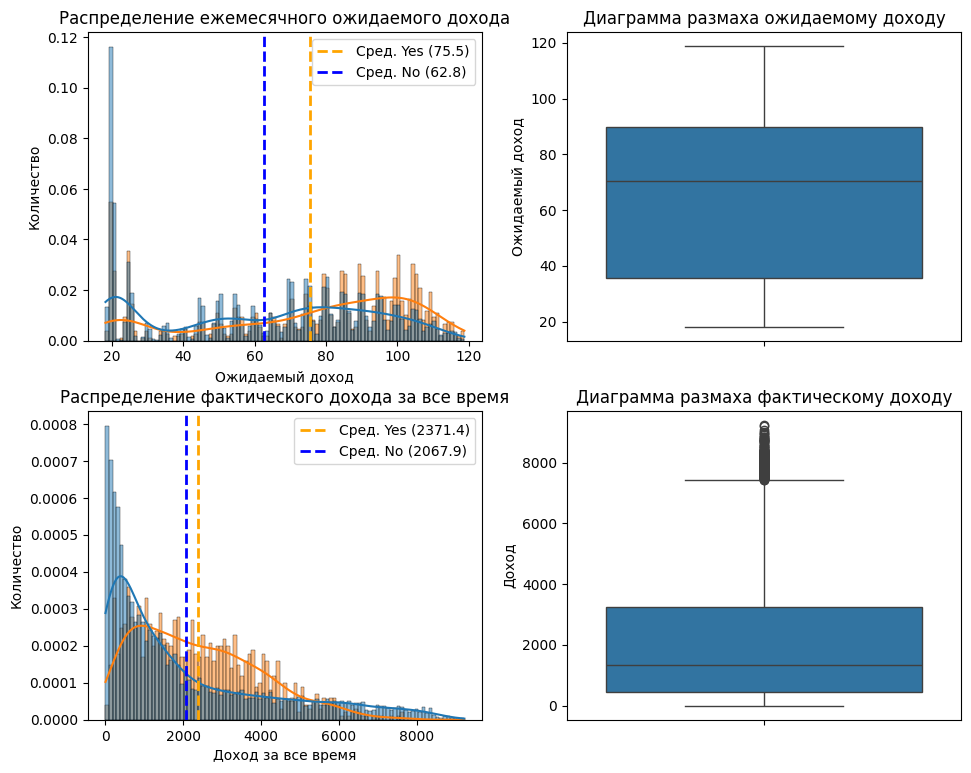

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plt.tight_layout(pad=3.0)

monthly_min = eda_frame['monthly_charges'].min()
monthly_max = eda_frame['monthly_charges'].max()
monthly_bins = int(monthly_max - monthly_min + 1)

sns.histplot(data=eda_frame, x='monthly_charges', kde=True, common_norm=False,
             bins=monthly_bins, hue='quit', stat='density', ax=axes[0, 0])

for status, color in zip(['Yes', 'No'], ['orange', 'blue']):
    mean_value = eda_frame[eda_frame['quit'] == status]['monthly_charges'].mean()
    axes[0, 0].axvline(mean_value, color=color, linestyle='--', linewidth=2,
                      label=f'Сред. {status} ({mean_value:.1f})')

axes[0, 0].set_title('Распределение ежемесячного ожидаемого дохода')
axes[0, 0].set_xlabel('Ожидаемый доход')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].legend()

sns.boxplot(data=eda_frame, y='monthly_charges', ax=axes[0, 1])
axes[0, 1].set_title('Диаграмма размаха ожидаемому доходу')
axes[0, 1].set_ylabel('Ожидаемый доход')

sns.histplot(data=eda_frame, x='total_charges', kde=True, common_norm=False,
             bins=monthly_bins, hue='quit', stat='density', ax=axes[1, 0])

for status, color in zip(['Yes', 'No'], ['orange', 'blue']):
    mean_value = eda_frame[eda_frame['quit'] == status]['total_charges'].mean()
    axes[1, 0].axvline(mean_value, color=color, linestyle='--', linewidth=2,
                      label=f'Сред. {status} ({mean_value:.1f})')

axes[1, 0].set_title('Распределение фактического дохода за все время')
axes[1, 0].set_xlabel('Доход за все время')
axes[1, 0].set_ylabel('Количество')
axes[1, 0].legend()

sns.boxplot(data=eda_frame, y='total_charges', ax=axes[1, 1])
axes[1, 1].set_title('Диаграмма размаха фактическому доходу')
axes[1, 1].set_ylabel('Доход')
plt.show()

Если смотреть на графики плотности распределения, то видно, что в среднем люди от которых выше ожидаемый доход или фактический, чаще прекращают пользование услугами компании(не считая выбросов). Можно предположить, что чаще всего они уходят потому что нашли более выгодные предложения на рынке за те же пакеты услуг.

#### 4.2.1 Проверка гипотез

Из вывода по графикам выше можно составить гипотезы и проверить их.
<br>
Нулевая гипотеза - средний доход от ушедших и оставшихся клиентов одинаков
<br>
Односторонняя гипотеза - средний доход от ушедших клиентов выше, чем от оставшихся

In [43]:
quit_yes = eda_frame[eda_frame['quit'] == 'Yes']['total_charges']
quit_no = eda_frame[eda_frame['quit'] == 'No']['total_charges']

In [44]:
t_stat, p_value = st.ttest_ind(quit_yes, quit_no,
                               equal_var=False, alternative='greater')
print("\nРезультаты одностороннего t-теста для фактической выручки:")
print(f"t-статистика = {t_stat:.4f}")
print(f"p-значение = {p_value:.4f}")


Результаты одностороннего t-теста для фактической выручки:
t-статистика = 5.4664
p-значение = 0.0000


Очень низкое значение p_value указывает на сильную статистическую значимость различий между группами.

In [45]:
alpha = 0.05
if p_value < alpha:
    print("\n✓ Отвергаем нулевую гипотезу")
    print("Статистически значимые доказательства того, что фактический доход от  ушедших клиентов ВЫШЕ")
    print("Это подтверждает гипотезу, что клиенты с большими тратами чаще уходят")
else:
    print("\n✗ Не отвергаем нулевую гипотезу")
    print("Нет доказательств того, что фактический доход от ушедших клиентов выше")


✓ Отвергаем нулевую гипотезу
Статистически значимые доказательства того, что фактический доход от  ушедших клиентов ВЫШЕ
Это подтверждает гипотезу, что клиенты с большими тратами чаще уходят


### 4.3 Категориальные признаки

Строю графики категориальных признаков с учетом отношения к уходу клиентов

In [46]:
def plot_churn_distribution_advanced(data, column, ax, title, xlabel):

    churn_stats = data.groupby(column)['quit'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).reset_index()
    churn_stats.columns = [column, 'churn_rate']


    churn_stats = churn_stats.sort_values('churn_rate', ascending=False)

    overall_churn_rate = (data['quit'] == 'Yes').mean() * 100


    sns.barplot(data=churn_stats, x=column, y='churn_rate', ax=ax, color='skyblue')


    ax.axhline(y=overall_churn_rate, color='red', linestyle='--', linewidth=2,
               label=f'Средний уровень оттока: {overall_churn_rate:.1f}%')

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Процент оттока (%)')
    ax.grid(axis='y', linestyle='--')
    ax.legend()


    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    for i, (index, row) in enumerate(churn_stats.iterrows()):

        ax.text(i, row['churn_rate'] * 0.5, f'{row["churn_rate"]:.1f}%',
                ha='center', va='center', fontweight='bold', color='white')

    return ax

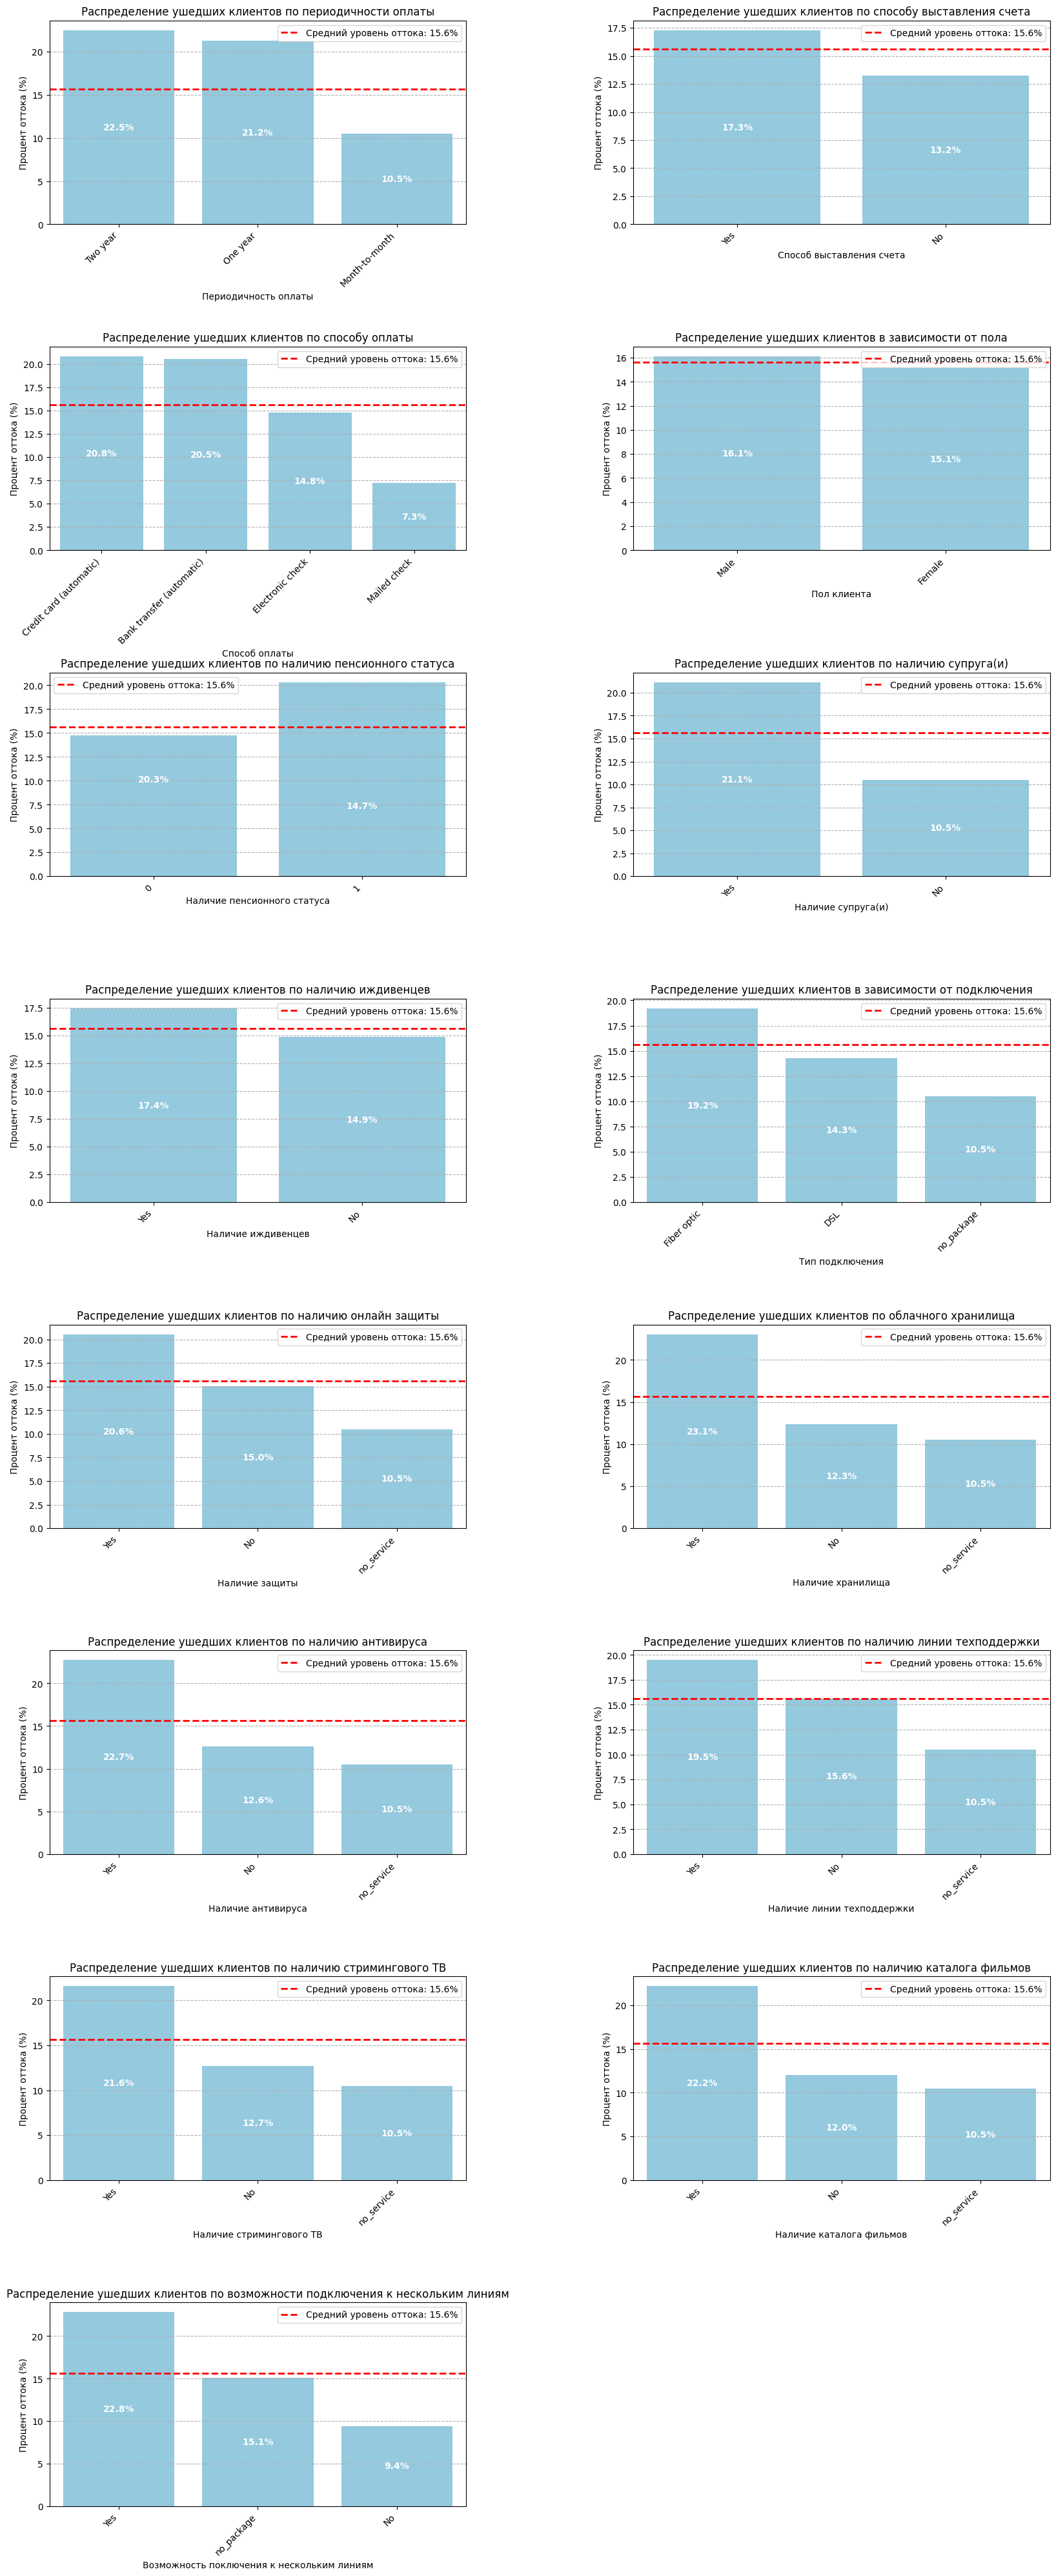

In [47]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 50))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

axes[7, 1].axis('off')

plot_churn_distribution_advanced(eda_frame, 'type', axes[0, 0],
                                 'Распределение ушедших клиентов по периодичности оплаты',
                                 'Периодичность оплаты')

plot_churn_distribution_advanced(eda_frame, 'paperless_billing', axes[0, 1],
                                 'Распределение ушедших клиентов по способу выставления счета',
                                 'Способ выставления счета')

plot_churn_distribution_advanced(eda_frame, 'payment_method', axes[1, 0],
                                 'Распределение ушедших клиентов по способу оплаты',
                                 'Способ оплаты')

plot_churn_distribution_advanced(eda_frame, 'gender', axes[1, 1],
                                 'Распределение ушедших клиентов в зависимости от пола',
                                 'Пол клиента')

plot_churn_distribution_advanced(eda_frame, 'senior_citizen', axes[2, 0],
                                 'Распределение ушедших клиентов по наличию пенсионного статуса',
                                 'Наличие пенсионного статуса')

plot_churn_distribution_advanced(eda_frame, 'partner', axes[2, 1],
                                 'Распределение ушедших клиентов по наличию супруга(и)',
                                 'Наличие супруга(и)')

plot_churn_distribution_advanced(eda_frame, 'dependents', axes[3, 0],
                                 'Распределение ушедших клиентов по наличию иждивенцев',
                                 'Наличие иждивенцев')

plot_churn_distribution_advanced(eda_frame, 'internet_service', axes[3, 1],
                                 'Распределение ушедших клиентов в зависимости от подключения',
                                 'Тип подключения')

plot_churn_distribution_advanced(eda_frame, 'online_security', axes[4, 0],
                                 'Распределение ушедших клиентов по наличию онлайн защиты',
                                 'Наличие защиты')

plot_churn_distribution_advanced(eda_frame, 'online_backup', axes[4, 1],
                                 'Распределение ушедших клиентов по облачного хранилища',
                                 'Наличие хранилища')

plot_churn_distribution_advanced(eda_frame, 'device_protection', axes[5, 0],
                                 'Распределение ушедших клиентов по наличию антивируса',
                                 'Наличие антивируса')

plot_churn_distribution_advanced(eda_frame, 'tech_support', axes[5, 1],
                                 'Распределение ушедших клиентов по наличию линии техподдержки',
                                 'Наличие линии техподдержки')

plot_churn_distribution_advanced(eda_frame, 'streaming_tv', axes[6, 0],
                                 'Распределение ушедших клиентов по наличию стримингового ТВ',
                                 'Наличие стримингового ТВ')

plot_churn_distribution_advanced(eda_frame, 'streaming_movies', axes[6, 1],
                                 'Распределение ушедших клиентов по наличию каталога фильмов',
                                 'Наличие каталога фильмов')

plot_churn_distribution_advanced(eda_frame, 'multiple_lines', axes[7, 0],
                                 'Распределение ушедших клиентов по возможности подключения к нескольким линиям',
                                 'Возможность поключения к нескольким линиям')

plt.show()

Из получившихся графиков можно составить примерный портрет клиента, который с большей вероятностью перестанет пользоваться услугами компании.
<br>
Это клиент с помесячной оплатой, получающий счет в электронном виде, совершающий оплату с помощью электронного чека. Пол клиента не столь важен. Чаще всего такой клиент не пенсионного возраста, у него есть супруг(а), нет иждивенцев. Такие клиенты в большинстве своем подключают пакет интеренет услуг. Чаще всего способ подключения интернета - fiber optic(что может говорить о качестве подключения). Такие клиенты реже пользуются блокировкой опасных сайтов, у них как правило есть онлайн хранилище и антивирус, но нет выделенной линии техподдержки. Они чаще подключают стриминговое тв и каталог фильмов, а также услугу подключения телефона к нескольким линиям одновременно.

### 4.4 Целевой признак

Строю график распределения целевого признака, чтобы оценить дисбаланс классов

/tmp/ipython-input-3950548127.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=eda_frame, x='quit', palette={'Yes': 'red', 'No': 'blue'})


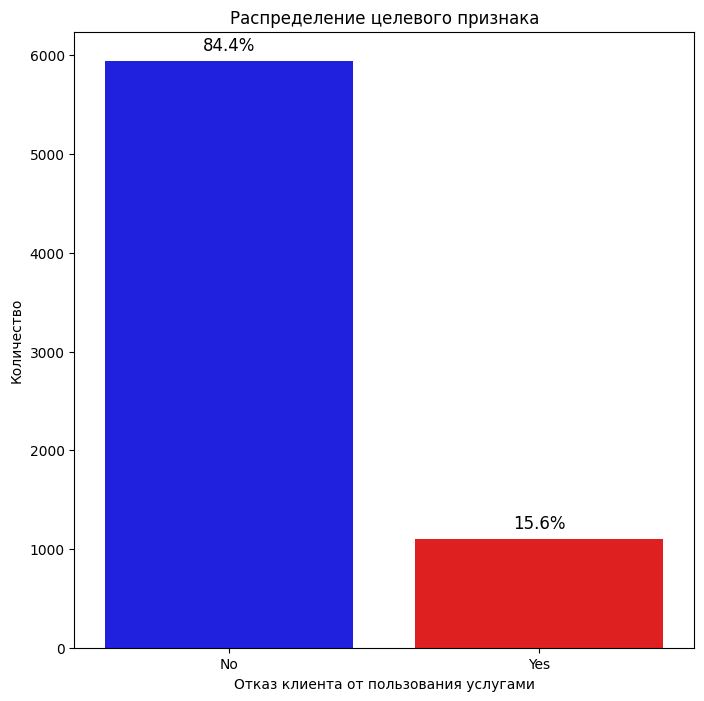

In [48]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(data=eda_frame, x='quit', palette={'Yes': 'red', 'No': 'blue'})
plt.title('Распределение целевого признака')
plt.xlabel('Отказ клиента от пользования услугами')
plt.ylabel('Количество')


total = len(eda_frame)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.01 * total
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

На графике виден сильный дисбаланс, в данных, людей которые продолжают пользоваться услугами компании гораздо больше тех, кто ушел. Это нужно будет учесть при обучении моделей.

**Вывод:** В данных прослеживается сильный дисбаланс классов. Был составлен примерный портрет пользователя, который откажется от услуг компании. Интересная деталь в том, что такие пользователи чаще пользуются пакетами услуг компании и сервисами в этих пакетах, но у них нет выделенной линии техподдержки. Так же стоит проверить качество подключения Fiber optic, так как там больший отток клиентов. Уходят преимущественно молодые люди без иждивенцев, и имеющие спругу(а).

## 5 Создание новых признаков

Создаю признак с длительностью контракта

In [49]:
eda_frame['end_date'] = eda_frame['end_date'].fillna('2020-02-01')

In [50]:
eda_frame['contract_duration'] = (eda_frame['end_date'] - eda_frame['begin_date']).dt.days
eda_frame.head(1)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,quit,contract_duration
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,2020-02-01,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,...,DSL,No,Yes,No,Yes,Yes,No,No,No,276


## 6 Корреляционный анализ

In [51]:
corr_df = eda_frame.drop(['begin_date', 'end_date'], axis=1)

In [52]:
interval_cols = ['monthly_charges', 'total_charges', 'contract_duration']

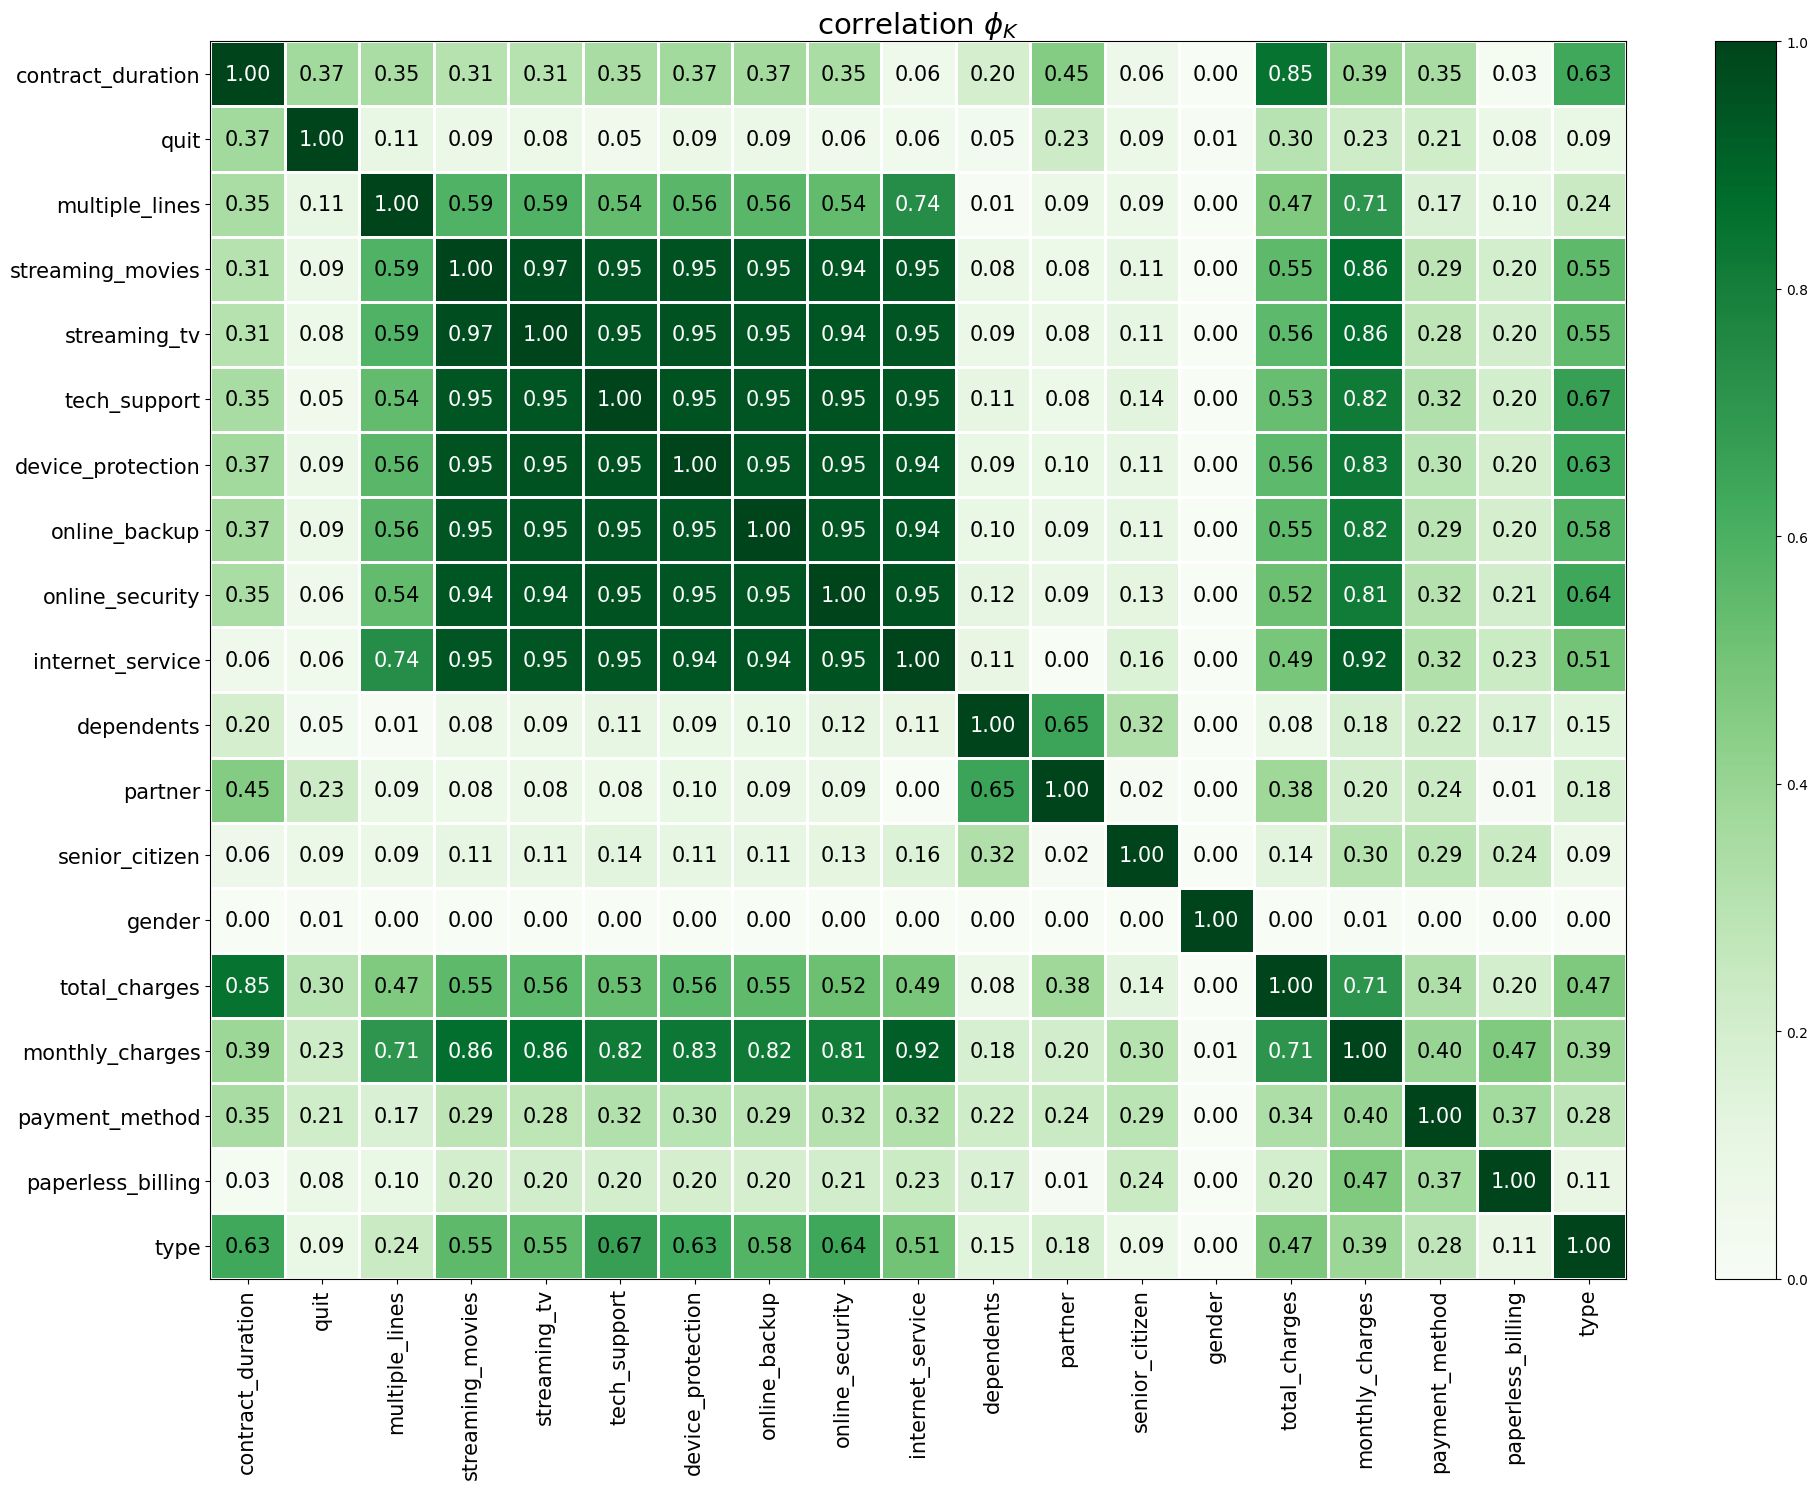

In [53]:
phik_overview = phik_matrix(corr_df, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Наблюдается мульиколлинеарность в блоке с сервисами из интернет-пакета. Оставляю столбец с основным пакетом и убираю сервисы из датафрейма.

In [54]:
corr_final = corr_df.drop(
    ['online_security', 'online_backup', 'device_protection',
     'tech_support', 'streaming_tv', 'streaming_movies'], axis=1)

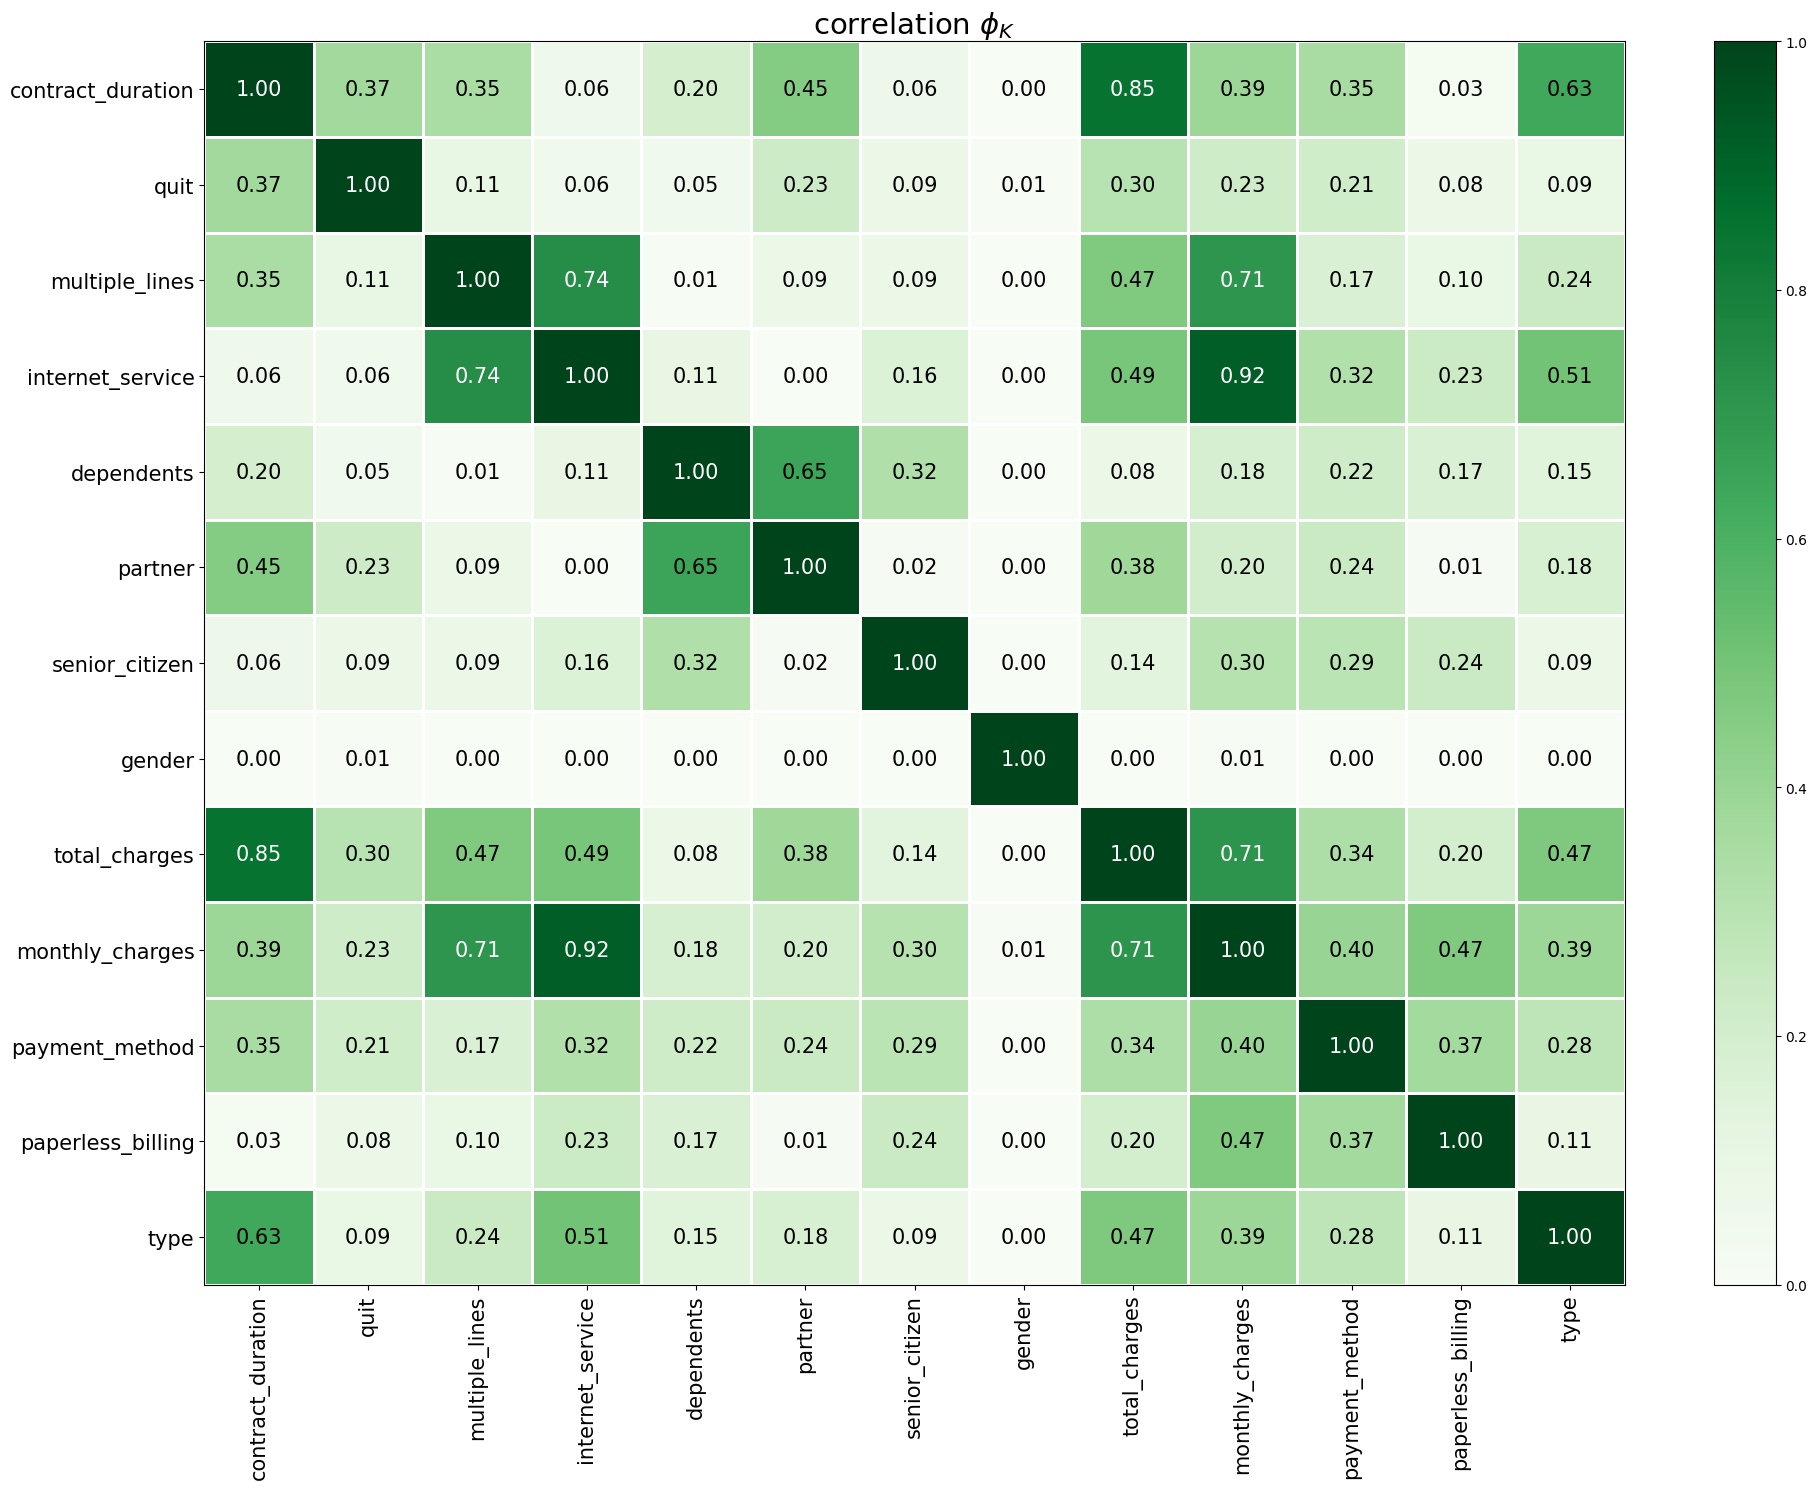

In [55]:
interval_cols = ['monthly_charges', 'total_charges', 'contract_duration']

phik_overview = phik_matrix(corr_final, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Теперь становится видна мультиколлинеарность признаков покдлючения интернета и ожидаемого месячного дохода от клиента. Тип подключения имеет меньшую корреляцию с целевым признаком, так что убираю его. Также видно, что признак gender почти никак не влияет на целевой признак, так что его тоже можно убрать.

In [56]:
final_df = corr_final.drop(['internet_service', 'gender'], axis=1)

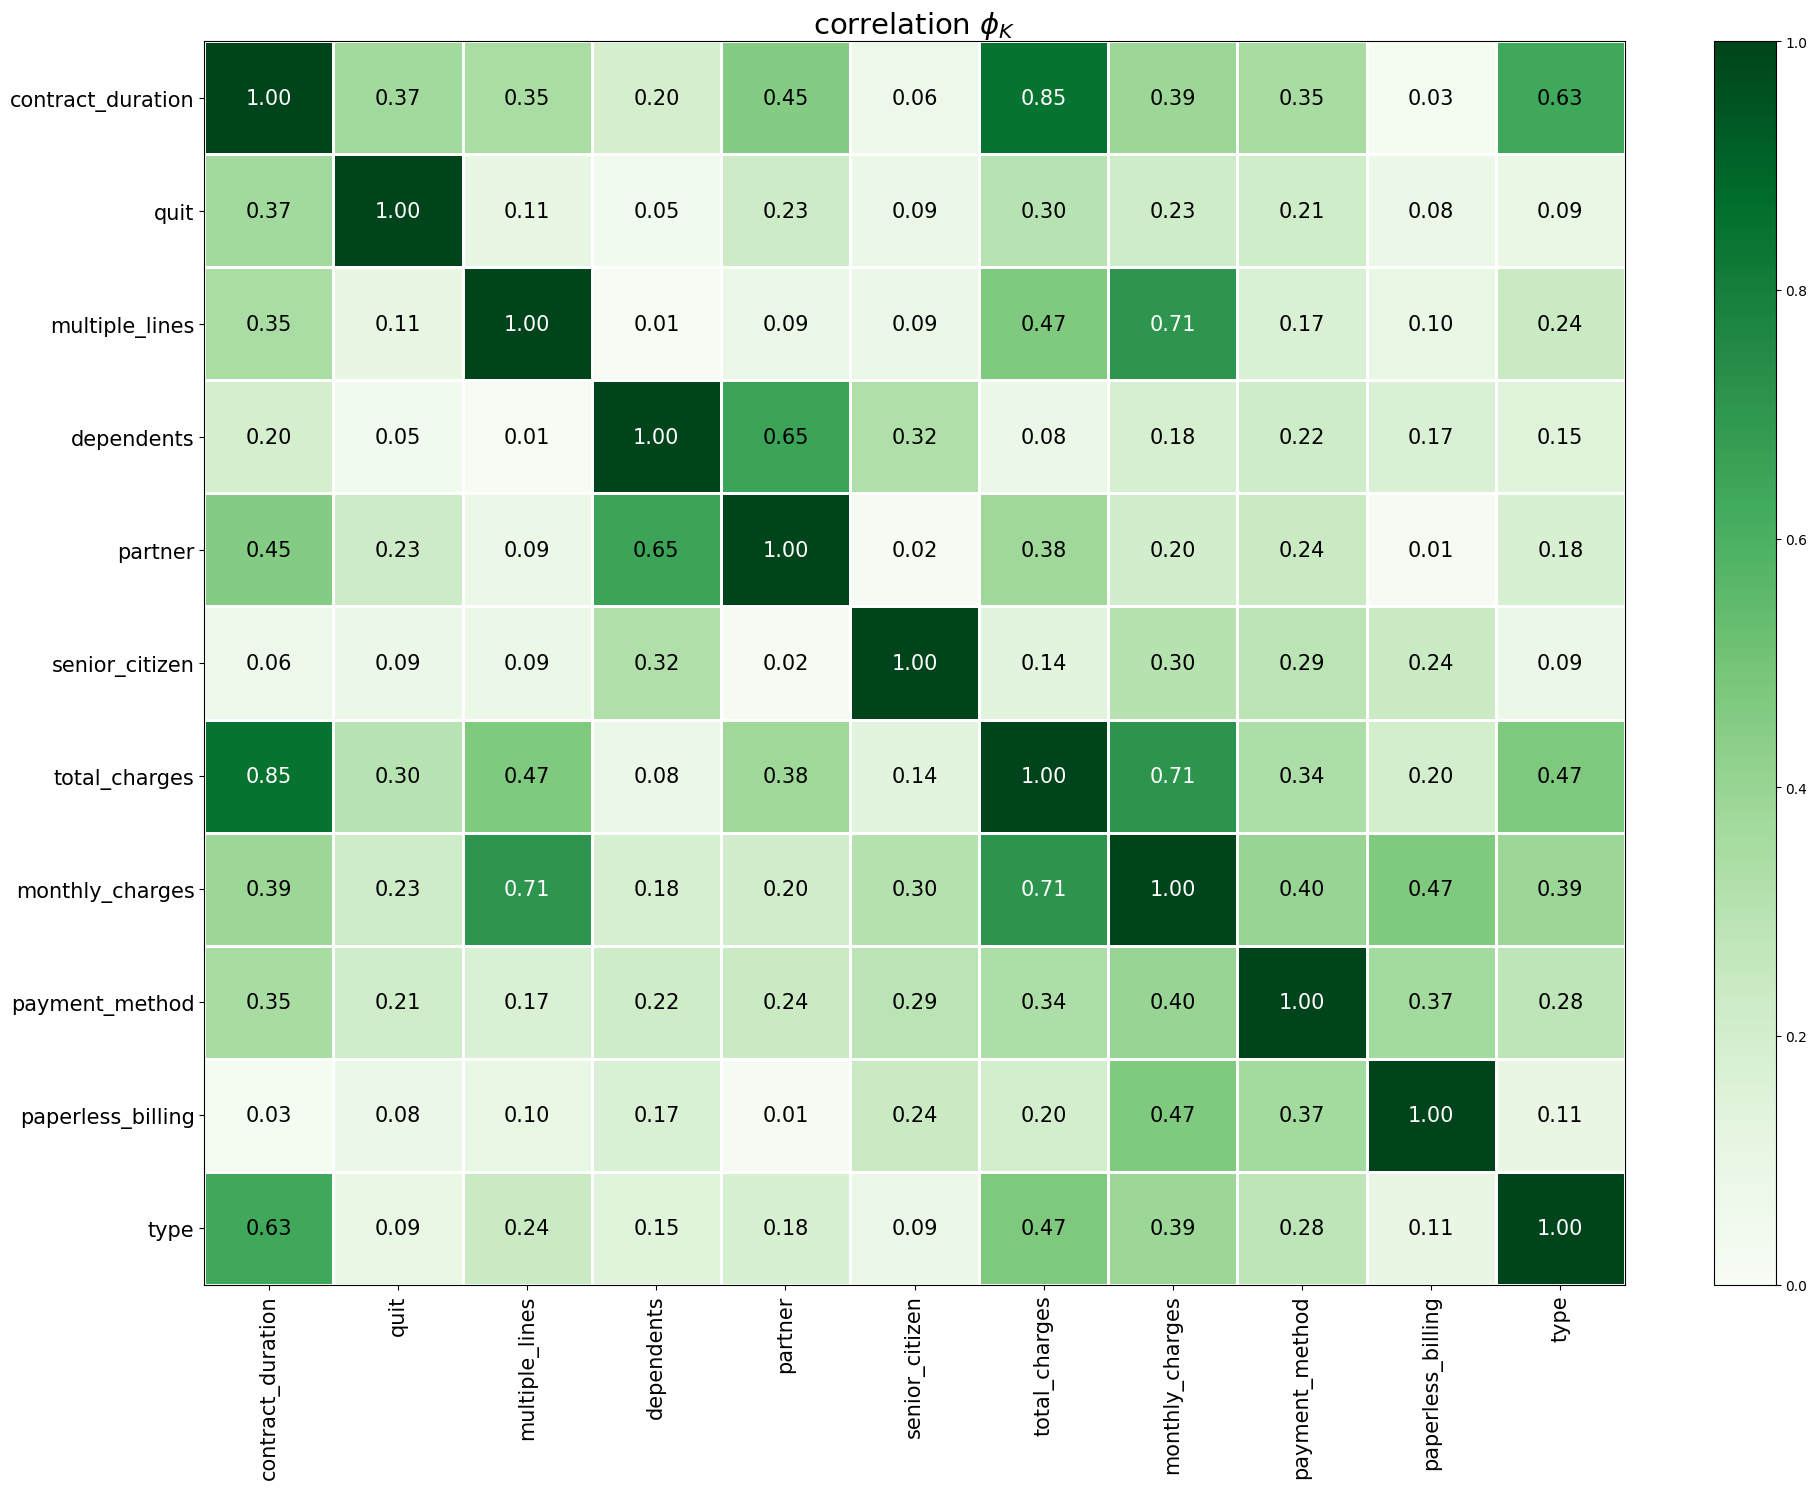

In [57]:
interval_cols = ['monthly_charges', 'total_charges', 'contract_duration']

phik_overview = phik_matrix(final_df, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Наиболее сильная корреляция целевого признака прослеживается с годом начала контракта, продолжительностью контракта и фактическим доходом от клиента за все время.

## 7 Подготовка данных к обучению моделей

Разбиваю данные на тренировочную и тестовую выборки, используя стратификацию, т.к. наблюдается сильный дисбаланс классов. Кодирую целевой признак с помощью LabelEncoder

In [58]:
RANDOM_STATE = 80925
TEST_SIZE = 0.25

X = final_df.drop('quit', axis=1)
y = final_df['quit']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

In [59]:
label_encoder_y = LabelEncoder()
y_train_encoded = label_encoder_y.fit_transform(y_train)
y_test_encoded = label_encoder_y.transform(y_test)

In [60]:
ord_columns = ['type', 'payment_method', 'paperless_billing',
               'senior_citizen', 'partner', 'dependents',
               'multiple_lines']
cat_features = ord_columns

num_columns = ['monthly_charges', 'contract_duration', 'total_charges']

In [61]:
ordinal_pipe = Pipeline([
    ('simpleImputer_ordinal', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

onehot_pipe = Pipeline([
    ('simpleImputer_onehot', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [62]:
data_preprocessor_ordinal = ColumnTransformer(
    [
    ('ordinal', ordinal_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
    )

data_preprocessor_onehot = ColumnTransformer(
    [
    ('onehot', onehot_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
    )

In [63]:
def objective(trial):

    model_type = trial.suggest_categorical('model_type', ['random_forest', 'catboost', 'logistic'])

    if model_type == 'random_forest':

        preprocessor = data_preprocessor_ordinal
        n_estimators = trial.suggest_int('rf_n_estimators', 50, 500)
        max_depth = trial.suggest_int('rf_max_depth', 5, 30)
        min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 10)
        max_features = trial.suggest_int('rf_max_features', 2, 15)

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    elif model_type == 'catboost':

        preprocessor = 'passthrough'
        iterations = trial.suggest_int('cb_iterations', 100, 500)
        depth = trial.suggest_int('cb_depth', 4, 8)
        learning_rate = trial.suggest_float('cb_learning_rate', 0.01, 0.1)
        l2_leaf_reg = trial.suggest_float('cb_l2_leaf_reg', 1, 5)

        model = CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            random_state=RANDOM_STATE,
            verbose=False,
            cat_features=cat_features,
            thread_count=-1
        )

    else:

        preprocessor = data_preprocessor_onehot
        C = trial.suggest_float('lr_C', 1e-4, 1e4, log=True)

        model = LogisticRegression(
            C=C,
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l2',
            max_iter=1000,
            n_jobs=-1
        )


    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('models', model)
    ])


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, X_train, y_train_encoded,
                           cv=cv, scoring='roc_auc', n_jobs=-1)

    return scores.mean()

## 8 Обучение моделей

### 8.1 Обучение

Обучаю несколько моделей и вывожу метрики лучшей из них

In [64]:
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE)
)


study.optimize(objective, n_trials=50, n_jobs=1)
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ OPTUNA")
print("="*60)
print(f"Лучшее ROC-AUC: {study.best_value:.4f}")
print(f"Лучшие параметры: {study.best_params}")

[I 2025-10-03 11:16:26,452] A new study created in memory with name: no-name-47eb6e27-c4cf-4533-9dca-0fdcb1db2eff
[I 2025-10-03 11:16:28,556] Trial 0 finished with value: 0.8129540313013818 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 64, 'rf_max_depth': 25, 'rf_min_samples_split': 13, 'rf_min_samples_leaf': 2, 'rf_max_features': 2}. Best is trial 0 with value: 0.8129540313013818.
[I 2025-10-03 11:16:36,155] Trial 1 finished with value: 0.8099799583671038 and parameters: {'model_type': 'random_forest', 'rf_n_estimators': 124, 'rf_max_depth': 18, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 5, 'rf_max_features': 14}. Best is trial 0 with value: 0.8129540313013818.
[I 2025-10-03 11:16:36,468] Trial 2 finished with value: 0.7565582833910882 and parameters: {'model_type': 'logistic', 'lr_C': 189.0672033977342}. Best is trial 0 with value: 0.8129540313013818.
[I 2025-10-03 11:16:36,785] Trial 3 finished with value: 0.7565555692503817 and parameters: {'model_type':


РЕЗУЛЬТАТЫ OPTUNA
Лучшее ROC-AUC: 0.9077
Лучшие параметры: {'model_type': 'catboost', 'cb_iterations': 460, 'cb_depth': 5, 'cb_learning_rate': 0.08884331072616533, 'cb_l2_leaf_reg': 1.0611035991543496}


In [65]:
best_params = study.best_params
model_type = best_params['model_type']

if model_type == 'random_forest':
    best_model = RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        min_samples_split=best_params['rf_min_samples_split'],
        min_samples_leaf=best_params['rf_min_samples_leaf'],
        max_features=best_params['rf_max_features'],
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    best_preprocessor = data_preprocessor_ordinal

elif model_type == 'catboost':
    best_model = CatBoostClassifier(
        iterations=best_params['cb_iterations'],
        depth=best_params['cb_depth'],
        learning_rate=best_params['cb_learning_rate'],
        l2_leaf_reg=best_params['cb_l2_leaf_reg'],
        random_state=RANDOM_STATE,
        verbose=False,
        cat_features=cat_features,
        thread_count=-1
    )
    best_preprocessor = 'passthrough'

else:
    best_model = LogisticRegression(
        C=best_params['lr_C'],
        random_state=RANDOM_STATE,
        solver='saga',
        penalty='l2',
        max_iter=1000,
        n_jobs=-1
    )
    best_preprocessor = data_preprocessor_onehot


best_pipe = Pipeline([
    ('preprocessor', best_preprocessor),
    ('models', best_model)
])

In [66]:
best_pipe.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor', 'passthrough'),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x7e9921f4cb00>)])

In [67]:
y_pred_proba = best_pipe.predict_proba(X_test)[:, 1]
y_pred = best_pipe.predict(X_test)

test_roc_auc = roc_auc_score(y_test_encoded, y_pred_proba)
test_accuracy = accuracy_score(y_test_encoded, y_pred)

print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВЫХ ДАННЫХ")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Тип модели: {model_type}")

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВЫХ ДАННЫХ
Test ROC-AUC: 0.9335
Test Accuracy: 0.9273
Тип модели: catboost


По итогу обучения лучшей моделью оказался CatBoostClassifier с метриками ROC-AUC 0.93 и accuracy 0.92 на тестовой выборке.

Высокое значение метрики ROC-AUC указывает на высокое качество модели бинарной классификации, несмотря на сильный дисбаланс классов в данных. Метрика accuracy указывает на обущю долю правильный предсказаний, здесь эта доля равна 92%, т.е. модель ошибается только в 8% случаев.

### 8.2 Оценка адекватности

Выполняю оценку модели на адекватность с помощью DummyClassifier

In [68]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train_encoded)

y_pred_dummy = dummy_clf.predict(X_test)
y_pred_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

In [69]:
accuracy = accuracy_score(y_test_encoded, y_pred_dummy)
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba_dummy)

In [70]:
print(accuracy)
print(roc_auc)

0.8438387279954571
0.5


Обе метрики на базовой модели получились ниже, что подтверждает эффективность выбранной в ходе подбора модели.

### 8.3 Анализ важности признаков

Строю график важности признаков

In [71]:
catboost_model = best_pipe.named_steps['models']

In [72]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)
feature_names = X_train.columns.tolist()

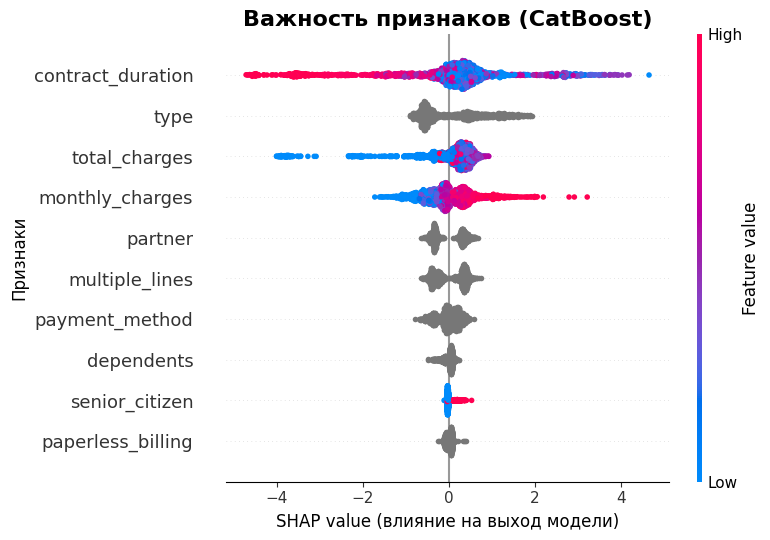

In [73]:
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=feature_names,
    plot_type="dot",
    show=False
)

ax = plt.gca()
ax.set_title("Важность признаков (CatBoost)", fontsize=16, fontweight='bold')
ax.set_ylabel("Признаки", fontsize=12)
ax.set_xlabel("SHAP value (влияние на выход модели)", fontsize=12)

plt.tight_layout()
plt.show()

На первом месте по значимости признак - contact_duration, чем ниже продолжительность контракта, тем выше шанс того, что модель впредскажет уход клиента.
<br>
Чем выше ожидаемые и фактические доходы от клиента, тем выше шанс того, что модель предскажет уход.
<br>
Достижение клиентом пенсионного возраста тоже влияет на результат работы модели. Если клиент достик пенсионного возраста, то модель скорее предскажет, что он перестанет пользоваться услугами.

### 8.4 Анализ матрицы ошибок

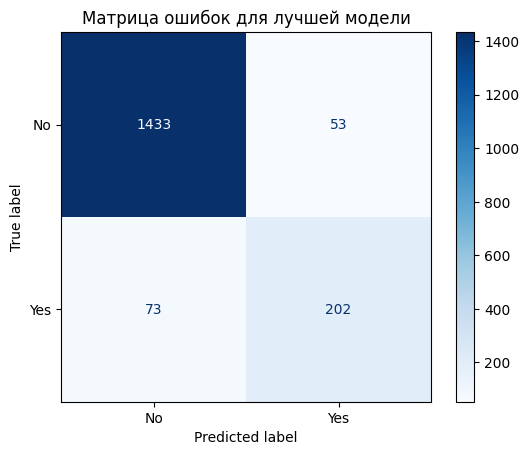

Матрица ошибок:
[[1433   53]
 [  73  202]]


In [74]:
best_model = best_pipe

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_pred_proba >= threshold).astype(int)


cm = confusion_matrix(y_test_encoded, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder_y.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Матрица ошибок для лучшей модели')
plt.show()


print("Матрица ошибок:")
print(cm)

На матрице ошибок видно:
1. 1433 -модель правильно предсказывает, что клиент останется
2. 53 - ложно-положительные ответы, модель пресказывает уход, но клиент остается
3. 73 - ложно-отрицательные ответы, модель предсказала, что клиент останется, но он ушел
4. 202 - правильно предсказанный уход клиентов

Можно сделать вывод, что модель неплохо справляется с предсказанием ухода клиентов. Но чтобы увеличить полноту предсказаний нужно больше данных об уходе клиентов.

## 9 Итоговый вывод

### 9.1 Анализ данных
В ходе исследовательского анализа был соствален примерный портрет клиента, который скорее всего закончит пользование услугами компании. А также обнаружен сильный дисбаланс классов в данных. В будущем нужно собрать больше данных об ушедших клиентах.

### 9.2 Обучение модели
В ходе обучения удалось добвиться значения метрики ROC-AUC - 0.93. Модель catboost лучше всего справилась с поставленной задачей. Общая доля верно предсказанных значений - 92%.

### 9.3 Рекомендации
Для улучшения точности модели стоит собрать больше данных о клиентах, сбалансировать классы. Исходя из исследовательского анализа уходят клиенты, которые активно пользуются пакетами услуг, что можем значить уход на более выгодные условия к другим операторам. Следует создать специальные предложения для активных постоянных клиентов, чтобы удержать их от ухода. Так же отталкиваясь от фактического дохода с клиента, возможно стоит сделать выделенную линию техподдержки.